Hier alle imports gewoon plaatsen denk ik, zouden het ook kunnen doen per deel maar niet dat het in random codeblocks staat

**Statlines**
- Bevolking = https://opendata.cbs.nl/#/CBS/nl/dataset/37230ned/table?dl=A564B 2019-2023 Niet gebruikt
- Inkomen = https://opendata.cbs.nl/#/CBS/nl/dataset/86005NED/table?dl=9552C 2021 Niet gebruikt
- Woningen = https://opendata.cbs.nl/#/CBS/nl/dataset/85035NED/table?dl=B40B6 2021
- Zonneenergie = https://opendata.cbs.nl/#/CBS/nl/dataset/85005NED/table?dl=B4AF7 2019-2021
- Gemeente namen = https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2021
- Inkomen & Leeftijd & Bevolking & oppervlaktes samen = https://opendata.cbs.nl/#/CBS/nl/dataset/70072ned/table?dl=B4C75 2019-2023 (Nu gebruikt) 
- Onderwijs = https://opendata.cbs.nl/statline/#/CBS/nl/dataset/85525NED/table?dl=B4C70 2021
- Dichtheid kan je uitrekenen met oppervlakte en woningen
- Missend zijn subsidie 
- Platte daken = https://www.atlasleefomgeving.nl/platte-daken-in-nederland-bag (evt eruit)
- Koopwoningen prijs = https://opendata.cbs.nl/statline/#/CBS/nl/dataset/83625NED/table?dl=B4E3B
- Landbouw = https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70262ned/table?dl=B4E42

IAPES (engels) wordt gebruikt voor de DF met Inkomen, leeftijd, Bevolking, oppervlaktes

In [904]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [905]:
# Path to the relevant geofiles
municipality_shapefile = "data/geo/gemeenten_2021_v3.shp"
provinces_shapefile = "data/geo/GRS_1000_PROV_NL_V.shp"

# Path to the relevant files
municipality_names_path = "data/gemeenten2021.csv"
housing_type_path = "data/woningtype_nieuw.csv"
solar_path = "data/zonnestroom.csv"
rooftop_path = "data/platdak.csv"
housing_price_path = "data/koopwoningen.csv"
farming_land_path = "data/landbouw.csv"
education_path = "data/onderwijs.csv"
IAPES_path = "data/IAPES.csv"

In [906]:
# Reading the other datasets as DataFrames
municipality_names_df = pd.read_csv(municipality_names_path, header=0, delimiter=';')
housing_type_df = pd.read_csv(housing_type_path, header=0, delimiter=';')
solar_df = pd.read_csv(solar_path, header=0, delimiter=';')
rooftop_df = pd.read_csv(rooftop_path, header=0, delimiter=';')
housing_price_df = pd.read_csv(housing_price_path, header=0, delimiter=';')
farming_land_df = pd.read_csv(farming_land_path, header=0, delimiter=';')
education_df = pd.read_csv(education_path, header=0, delimiter=';')
IAPES_df = pd.read_csv(IAPES_path, header=0, delimiter=';')

Eerst gemeenten namen checken omdat die relevant zijn voor de andere files. 

In [907]:
# Dataframe voor alle gemeenten namen in 2021
display(municipality_names_df)

,Gemeentecode,GemeentecodeGM,Gemeentenaam,Provinciecode,ProvinciecodePV,Provincienaam
0,1680,GM1680,Aa en Hunze,22,PV22,Drenthe
1,358,GM0358,Aalsmeer,27,PV27,Noord-Holland
2,197,GM0197,Aalten,25,PV25,Gelderland
3,59,GM0059,Achtkarspelen,21,PV21,Fryslân
4,482,GM0482,Alblasserdam,28,PV28,Zuid-Holland
...,...,...,...,...,...,...
347,879,GM0879,Zundert,30,PV30,Noord-Brabant
348,301,GM0301,Zutphen,25,PV25,Gelderland
349,1896,GM1896,Zwartewaterland,23,PV23,Overijssel
350,642,GM0642,Zwijndrecht,28,PV28,Zuid-Holland


### Preprocessing
Na het checken van de gemeente namen, het inladen van de gpd file. Vervolgens willen we eerst alle water gebieden van de gemeenten eruit halen, anders krijg je ook het water gebied waar de gemeenten verantwoordelijk voor zijn. Voor merge kolom hernoemen, we mergen om te checken of alles consistent is dus zowel gemeentennamen shapefile vs het gemeentennamen bestand uit 2021. Checken we straks tegen mergedf

In [908]:
# Laad de shapefile met GeoPandas voor zowel gemeenten als provincien
gdf_municipalities = gpd.read_file(municipality_shapefile)
gdf_provinces = gpd.read_file(provinces_shapefile)

# Filter for only municipalities (no water) and the year 2021
filtered_gdf_municipalities = gdf_municipalities[(gdf_municipalities['H2O'] == 'NEE')]

# Reset the index
filtered_gdf_municipalities = filtered_gdf_municipalities.reset_index(drop=True)

# Hernoem de GM kolom voor mergen
municipality_names_df = municipality_names_df.rename(columns={'Gemeentenaam':'GM_NAAM'})

# Merge the filtered and unique GeoDataFrame with the municipality names DataFrame
gdf_municipalities_merged = filtered_gdf_municipalities.merge(
    municipality_names_df,
    on="GM_NAAM",
    how="inner"  # Ensures all rows from `municipality_names_df` are retained, checks if the names are the same
)

gdf_municipalities_merged.to_crs(epsg=4326, inplace=True)
gdf_provinces.to_crs(epsg=4326, inplace=True)

display(gdf_municipalities_merged)

,OBJECTID,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,...,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry,Gemeentecode,GemeentecodeGM,Provinciecode,ProvinciecodePV,Provincienaam
0,84.0,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,...,2021GM0014,2021,98454.011519,1.979605e+08,"POLYGON ((6.74099 53.31197, 6.7413 53.31179, 6...",14,GM0014,20,PV20,Groningen
1,85.0,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,...,2021GM0034,2021,77001.560698,1.392038e+08,"MULTIPOLYGON (((5.21106 52.33159, 5.21107 52.3...",34,GM0034,24,PV24,Flevoland
2,86.0,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,...,2021GM0037,2021,64057.948253,1.199441e+08,"POLYGON ((7.01013 53.0737, 7.0127 53.07029, 7....",37,GM0037,20,PV20,Groningen
3,87.0,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,...,2021GM0047,2021,39605.318697,7.867884e+07,"POLYGON ((6.90368 53.12754, 6.90423 53.12748, ...",47,GM0047,20,PV20,Groningen
4,88.0,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,...,2021GM0050,2021,98901.663241,2.525283e+08,"MULTIPOLYGON (((5.539 52.29363, 5.53912 52.293...",50,GM0050,24,PV24,Flevoland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,431.0,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,...,2021GM1966,2021,321301.166576,4.875998e+08,"MULTIPOLYGON (((6.28864 53.34051, 6.28885 53.3...",1966,GM1966,20,PV20,Groningen
348,432.0,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,...,2021GM1969,2021,99030.762281,3.688457e+08,"POLYGON ((6.29076 53.33842, 6.29082 53.33837, ...",1969,GM1969,20,PV20,Groningen
349,433.0,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,...,2021GM1970,2021,238426.959926,3.837930e+08,"MULTIPOLYGON (((6.18131 53.41465, 6.182 53.414...",1970,GM1970,21,PV21,Fryslân
350,434.0,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,...,2021GM1978,2021,88570.376691,1.915841e+08,"POLYGON ((4.93003 51.94875, 4.93013 51.94865, ...",1978,GM1978,28,PV28,Zuid-Holland


In [909]:
gdf_provinces

,OBJECTID,PROVINCIEN,PROV_CODE,SHAPE_AREA,SHAPE_LEN,geometry
0,1,Drenthe,22,2.681828e+09,256068.158565,"POLYGON ((6.50931 53.19905, 6.51339 53.19694, ..."
1,2,Flevoland,24,2.413784e+09,236399.542975,"POLYGON ((5.78966 52.80461, 5.79052 52.80444, ..."
2,3,Fryslân,21,5.752659e+09,372906.901681,"POLYGON ((6.35347 53.52219, 6.35526 53.52214, ..."
3,4,Gelderland,25,5.134151e+09,503602.034611,"POLYGON ((5.94054 52.47734, 5.96029 52.47668, ..."
4,5,Groningen,20,2.955313e+09,299249.614826,"POLYGON ((6.64833 53.57007, 6.66743 53.56061, ..."
5,6,Limburg,31,2.207753e+09,419141.407850,"POLYGON ((5.93573 51.74145, 5.93723 51.74141, ..."
6,7,Noord-Brabant,30,5.083624e+09,466209.109788,"POLYGON ((5.53497 51.81662, 5.5384 51.8163, 5...."
7,8,Noord-Holland,27,4.092688e+09,380179.016742,"POLYGON ((5.37726 52.76481, 5.36115 52.67573, ..."
8,9,Overijssel,23,3.422124e+09,380489.409371,"POLYGON ((6.13677 52.83899, 6.16976 52.8166, 6..."
9,10,Utrecht,26,1.559616e+09,261524.261576,"POLYGON ((5.02361 52.28204, 5.02697 52.28185, ..."


Provincie grenzen over de gemeente kaart leggen, probleem is alleen dat de provincie grenzen met water zijn, dit zorgt voor wat moeilijkheden mbt het plotten.

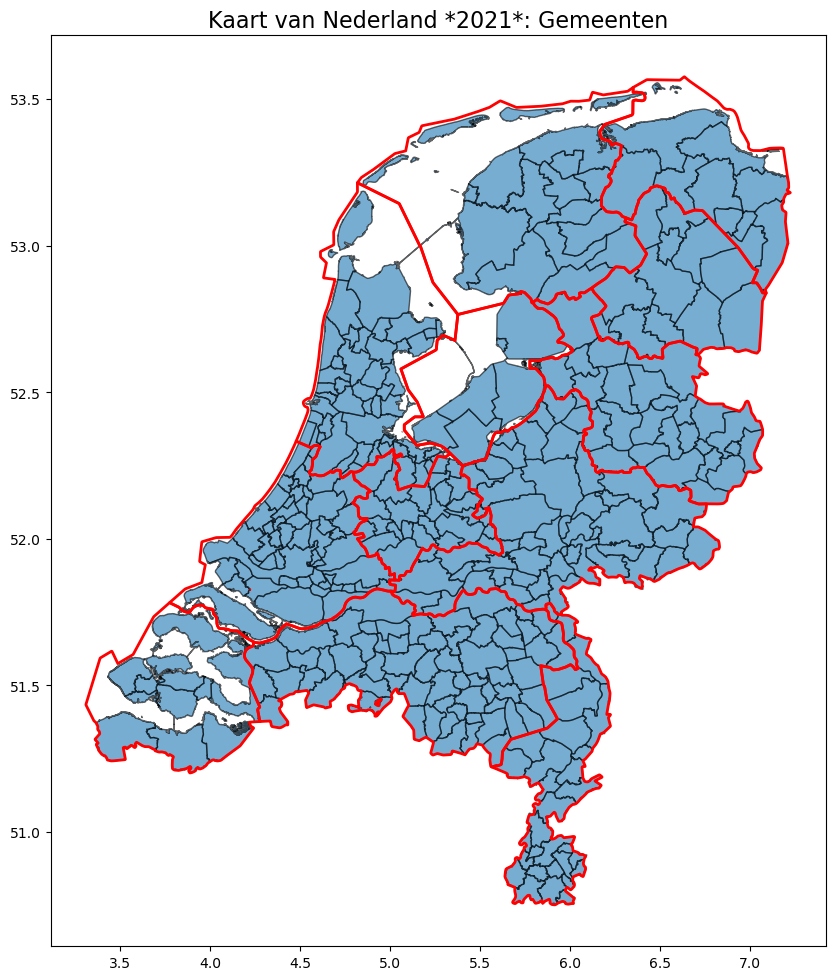

In [910]:
# Plot de kaart van Nederland met gemeenten en provinciën
fig, ax = plt.subplots(figsize=(10, 12))
gdf_municipalities_merged.plot(ax=ax, edgecolor='black', alpha=0.6)

# Overlay the provinces with red edges
gdf_provinces.plot(ax=ax, edgecolor='red', linewidth=2, facecolor="none")

plt.title("Kaart van Nederland *2021*: Gemeenten", fontsize=16)

plt.show()

In [911]:
display(housing_type_df)

,Regio's,Woningtype,Perioden,Beginstand woningvoorraad (aantal)
0,Nederland,Totaal woningen,2021,7966331.0
1,Nederland,Meergezinswoningen totaal,2021,2870532.0
2,Nederland,Eengezinswoningen totaal,2021,5095799.0
3,Nederland,Vrijstaande woning,2021,1035389.0
4,Nederland,2-onder-1-kapwoning,2021,698022.0
...,...,...,...,...
2859,Buitenland,Vrijstaande woning,2021,NaN
2860,Buitenland,2-onder-1-kapwoning,2021,NaN
2861,Buitenland,Hoekwoning,2021,NaN
2862,Buitenland,Tussenwoning,2021,NaN


In [912]:
# Get unique woningtypes from the 'Woningtype' column
unique_woningen = housing_type_df['Woningtype'].unique()

# Print the unique woningtypes
print("Unieke woningtypes in de kolom 'Woningtype':")
for woning in unique_woningen:
    print(woning)

Unieke woningtypes in de kolom 'Woningtype':
Totaal woningen
Meergezinswoningen totaal
Eengezinswoningen totaal
Vrijstaande woning
2-onder-1-kapwoning
Hoekwoning
Tussenwoning
Onbekend woningtype eengezinswoning


# Beschrijving van de Dataset

## Inhoud
De dataset bevat informatie over woningtypes in Nederland en hun aantallen per categorie. Het doel is om inzicht te geven in de verdeling van verschillende woningtypes en hun kenmerken, zoals het totale aantal woningen en de onderverdeling in specifieke categorieën.
### Belangrijke Kolommen
1. **Regio's**: De geografische regio's, zoals gemeenten of Nederland als geheel.
2. **Woningtype**: Het type woning.
3. **Perioden**: Het jaar waarop de data betrekking heeft (bijvoorbeeld 2021).
4. **Beginstand woningvoorraad (aantal)**: Het aantal woningen aan het begin van de periode.

#### **- Totaal woningen**
- **Type woning**: Overkoepelende categorie die alle woningtypes omvat, inclusief zowel eengezins- als meergezinswoningen.
- **Invloed op zonnepanelen**: Dit is een aggregaatcategorie, dus de invloed varieert afhankelijk van het specifieke woningtype.

#### **- Meergezinswoningen totaal**
- **Type woning**: Woningen in een gebouw dat meerdere huishoudens huisvest, zoals flats en appartementen.
- **Invloed op zonnepanelen**:
  - Het dak wordt gedeeld door meerdere huishoudens, waardoor individuele plaatsing niet mogelijk is.
  - Plaatsing vereist samenwerking via bijvoorbeeld een Vereniging van Eigenaren (VvE) of een collectief project.

#### **- Eengezinswoningen totaal**
- **Type woning**: Grondgebonden woningen bedoeld voor één huishouden, waaronder vrijstaande woningen, hoekwoningen, tussenwoningen en twee-onder-een-kapwoningen.
- **Invloed op zonnepanelen**:
  - Dak is meestal volledig in eigendom van het huishouden.
  - Ideaal voor individuele plaatsing van zonnepanelen zonder organisatorische beperkingen.

#### **- Vrijstaande woning**
- **Type woning**: Een woning die volledig vrijstaat, zonder gemeenschappelijke muren met andere woningen.
- **Invloed op zonnepanelen**:
  - Het hele dak is beschikbaar voor zonnepanelen.
  - Geen schaduw van aangrenzende gebouwen; maximale flexibiliteit in plaatsing.

#### **- 2-onder-1-kapwoning**
- **Type woning**: Twee woningen die samen één gebouw vormen en een gemeenschappelijke muur delen.
- **Invloed op zonnepanelen**:
  - Elk huishouden heeft zijn eigen dakhelft, wat zelfstandige plaatsing mogelijk maakt.
  - Dakoriëntatie kan verschillen per woning, wat de opbrengst kan beïnvloeden.

#### **- Hoekwoning**
- **Type woning**: Een woning aan het uiteinde van een rij, vaak met extra buitenruimte en een zijmuur.
- **Invloed op zonnepanelen**:
  - Dak is eigendom van de bewoner, zonder gedeelde eigendomsrechten.
  - Minder kans op schaduw van aangrenzende woningen, vooral aan de vrije zijde.

#### **- Tussenwoning**
- **Type woning**: Een woning die zich in het midden van een rij woningen bevindt, met muren aan beide zijden gedeeld met buren.
- **Invloed op zonnepanelen**:
  - Het dak is eigendom van de bewoner, maar de beschikbare ruimte is vaak beperkt.
  - Mogelijke schaduw van aangrenzende woningen kan de opbrengst beïnvloeden.

# Conclusie
Voor de analyse wordt onderscheid gemaakt tussen twee woningtypes: **Eengezinswoningen totaal** en **Meergezinswoningen totaal**

In [913]:
# Unstacking based on 'Woningtype'
housing_type_df = housing_type_df.pivot_table(
    index=["Regio's", 'Perioden'], 
    columns='Woningtype', 
    values='Beginstand woningvoorraad (aantal)'
).reset_index()

display(housing_type_df)

Woningtype,Regio's,Perioden,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0
...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0


In [914]:


display(housing_type_df)

Woningtype,Regio's,Perioden,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0
...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0


In [915]:


display(solar_df)

,Sector en vermogensklasse,Regio's,Perioden,Installaties (aantal),Opgesteld vermogen van zonnepanelen (kWp),Opgesteld vermogen omvormers (kW),Productie van zonnestroom (mln kWh)
0,Woningen,Nederland,2019,960248.0,3236417.0,NaN,2620
1,Woningen,Nederland,2020,1267651.0,4488623.0,NaN,3714
2,Woningen,Nederland,2021,1611689.0,5843084.0,NaN,4652
3,Woningen,Nederland,2022,2131019.0,8014761.0,7619597.0,6760
4,Woningen,Aa en Hunze,2019,2573.0,10050.0,NaN,.
...,...,...,...,...,...,...,...
1443,Woningen,Zwolle,2022,18575.0,60879.0,58328.0,.
1444,Woningen,Gemeenten; niet in te delen,2019,352.0,792.0,NaN,1
1445,Woningen,Gemeenten; niet in te delen,2020,423.0,1460.0,NaN,1
1446,Woningen,Gemeenten; niet in te delen,2021,348.0,817.0,NaN,1


**Daken** 

In plaats van dakoriëntatie hebben we uiteindelijk gekozen voor het aantal platte daken per gemeente. Dit heeft twee redenen, ten eerste is hier een dataset voor, ten tweede stond in deze dataset ook voor gezinswoningen de hoeveelheid platte daken. Platte daken zijn interessant omdat juist hierop zonnepanelen maar ook daktuinen aangelegd kunnen worden door particulieren. Eerst worden de woningen gekozen met rooftop_df['Gebruiksfunctie'] == 'woonfunctie'. 

In [916]:
# Propagate 'Gemeentenaam 2021' downwards to fill NaN values
rooftop_df['Gemeentenaam 2021'] = rooftop_df['Gemeentenaam 2021'].fillna(method='ffill')

# Rename column to fit the common merge scheme
rooftop_df = rooftop_df.rename(columns={'Gemeentenaam 2021': "Regio's"})

# Drop the 'Gemeentenummer 2021' column
rooftop_df = rooftop_df.drop(columns=['Gemeentenummer 2021'])

# Only select homes since we are looking at consumer solar panels and possibilites
rooftop_homes_df = rooftop_df[rooftop_df['Gebruiksfunctie'] == 'woonfunctie']

rooftop_homes_df = rooftop_homes_df.reset_index(drop=True)

display(rooftop_homes_df)



C:\Users\juliu\AppData\Local\Temp\ipykernel_22748\3007145089.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rooftop_df['Gemeentenaam 2021'] = rooftop_df['Gemeentenaam 2021'].fillna(method='ffill')


,Regio's,Gebruiksfunctie,Geen plat dak (m2),Wel plat dak (m2),Onbekend (m2),Dakoppervlak totaal (m2)
0,Nederland,woonfunctie,392358906,155219511,8962633,556541051
1,Groningen (gemeente),woonfunctie,3220762,2531769,161576,5914107
2,Almere,woonfunctie,2529755,2332920,194086,5056762
3,Stadskanaal,woonfunctie,1242774,307563,23986,1574322
4,Veendam,woonfunctie,925117,248579,15320,1189016
...,...,...,...,...,...,...
348,Het Hogeland,woonfunctie,2842222,405148,48334,3295705
349,Westerkwartier,woonfunctie,2845242,512152,91725,3449119
350,Noardeast-Fryslân,woonfunctie,2104950,486412,22695,2614057
351,Molenlanden,woonfunctie,1298540,155674,26956,1481169


Origineel had de dataset voor de daken nog een paar niet matchende namen, zo stond er Utrecht, ipv Utrecht (gemeente), en stond er Bergen (NH) ipv Bergen (NH.) anders dan in de datasets van CBS. Dit is handmatig aangepast om zo the matchen. De andere kant op bevatten de cbs datasets nog gemeenten die al zijn opgeheven maar die worden er aan het einde pas uitgefilterd.

In [917]:
# Step 1: Find unmatched entries
unmatched_entries = rooftop_homes_df[~rooftop_homes_df["Regio's"].isin(solar_df["Regio's"])]
print(unmatched_entries["Regio's"].unique())

# Step 1: Find unmatched entries
unmatched_entries = solar_df[~solar_df["Regio's"].isin(rooftop_homes_df["Regio's"])]
print(unmatched_entries["Regio's"].unique())

[]
['Appingedam' 'Delfzijl' 'Dijk en Waard' 'Haaren' 'Land van Cuijk'
 'Loppersum' 'Maashorst' 'Voorne aan Zee' 'Gemeenten; niet in te delen']


In [918]:
display(housing_price_df)

,Regio's,Perioden,Gemiddelde verkoopprijs (euro)
0,Aa en Hunze,2021,393780.0
1,Aalburg,2021,NaN
2,Aalsmeer,2021,538786.0
3,Aalten,2021,306386.0
4,Ter Aar,2021,NaN
...,...,...,...
723,Zwartewaterland,2021,291968.0
724,Zwartsluis,2021,NaN
725,Zweeloo,2021,NaN
726,Zwijndrecht,2021,306639.0


In [919]:
farming_land_df = farming_land_df.drop(columns=['Perioden'])
display(farming_land_df)

,Regio's,Totale oppervlakte (ha),Agrarisch terrein/Totaal agrarisch terrein (ha)
0,Aa en Hunze,27887.0,18749.0
1,Altena,22500.0,15500.0
2,Aalsmeer,3229.0,763.0
3,Aalten,9705.0,8046.0
4,Ter Aar,NaN,NaN
...,...,...,...
695,Zwartewaterland,8786.0,6765.0
696,Zwartsluis,NaN,NaN
697,Zweeloo,NaN,NaN
698,Zwijndrecht,2277.0,542.0


In [920]:
display(education_df)

,Geslacht,Leeftijd,Perioden,Regio's,Bevolking (aantal),Onderwijsniveau 3 categorieën/1 Laag onderwijsniveau (%),Onderwijsniveau 3 categorieën/2 Middelbaar onderwijsniveau (%),Onderwijsniveau 3 categorieën/3 Hoog onderwijsniveau (%)
0,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Nederland,13300700.0,26.5,41.8,31.7
1,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Aa en Hunze,19200.0,22.3,46.5,31.3
2,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Aalburg,NaN,NaN,NaN,NaN
3,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Aalsmeer,23900.0,28.6,42.7,28.7
4,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Aalten,20100.0,29.5,48.5,22.0
...,...,...,...,...,...,...,...,...
427,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Zundert,17100.0,30.1,46.3,23.6
428,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Zutphen,36900.0,27.1,41.2,31.7
429,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Zwartewaterland,16700.0,34.5,47.7,17.8
430,Totaal mannen en vrouwen,15 tot 75 jaar,2021,Zwijndrecht,32600.0,31.0,47.0,22.0


In [921]:
IAPES_df.columns.tolist()

['Perioden',
 "Regio's",
 'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/Jonger dan 5 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/5 tot 10 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/10 tot 15 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/15 tot 20 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/20 tot 25 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/25 tot 45 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/45 tot 65 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/65 tot 80 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari

In [922]:
# Filtering for 2021
housing_type_df_2021 = housing_type_df[housing_type_df['Perioden'] == 2021]
solar_df_2021 = solar_df[solar_df['Perioden'] == 2021]
IAPES_df_2021 = IAPES_df[IAPES_df['Perioden'] == 2021]

# Merging on 'Regio's'
merged_df = housing_type_df_2021.merge(
    solar_df_2021, on="Regio's", suffixes=('_housing', '_solar')
).merge(
    IAPES_df_2021, on="Regio's", suffixes=('', '_IAPES')
).merge(
    rooftop_homes_df, on="Regio's", suffixes=('', '_rooftop')
).merge(
    education_df, on="Regio's", suffixes=('', '_education')
).merge(
    housing_price_df, on="Regio's", suffixes=('', '_housing')
).merge(
    farming_land_df, on="Regio's", suffixes=('', '_housing')
)
display(merged_df)

,Regio's,Perioden_housing,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning,...,Leeftijd,Perioden_education,Bevolking (aantal),Onderwijsniveau 3 categorieën/1 Laag onderwijsniveau (%),Onderwijsniveau 3 categorieën/2 Middelbaar onderwijsniveau (%),Onderwijsniveau 3 categorieën/3 Hoog onderwijsniveau (%),Perioden_housing,Gemiddelde verkoopprijs (euro),Totale oppervlakte (ha),Agrarisch terrein/Totaal agrarisch terrein (ha)
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0,...,15 tot 75 jaar,2021,426100.0,29.4,34.4,36.2,2021,411717.0,9813.0,177.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0,...,15 tot 75 jaar,2021,120500.0,25.3,35.9,38.8,2021,412222.0,11807.0,5463.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0,...,15 tot 75 jaar,2021,19200.0,22.3,46.5,31.3,2021,393780.0,27887.0,18749.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0,...,15 tot 75 jaar,2021,23900.0,28.6,42.7,28.7,2021,538786.0,3229.0,763.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0,...,15 tot 75 jaar,2021,20100.0,29.5,48.5,22.0,2021,306386.0,9705.0,8046.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0,...,15 tot 75 jaar,2021,17100.0,30.1,46.3,23.6,2021,381275.0,12121.0,9536.0
348,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0,...,15 tot 75 jaar,2021,36900.0,27.1,41.2,31.7,2021,324899.0,4293.0,1944.0
349,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0,...,15 tot 75 jaar,2021,16700.0,34.5,47.7,17.8,2021,291968.0,8786.0,6765.0
350,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0,...,15 tot 75 jaar,2021,32600.0,31.0,47.0,22.0,2021,306639.0,2277.0,542.0


In [923]:
# Municipalities in merged_df before merging farming_land_df
merged_df_before = housing_type_df_2021.merge(
    solar_df_2021, on="Regio's", suffixes=('_housing', '_solar')
).merge(
    IAPES_df_2021, on="Regio's", suffixes=('', '_IAPES')
).merge(
    rooftop_homes_df, on="Regio's", suffixes=('', '_rooftop')
).merge(
    education_df, on="Regio's", suffixes=('', '_education')
).merge(
    housing_price_df, on="Regio's", suffixes=('', '_housing')
)

# Get the set of municipalities before merging farming_land_df
municipalities_before = set(merged_df_before["Regio's"])

# Get the set of municipalities in farming_land_df
municipalities_farming_land = set(farming_land_df["Regio's"])

# Find municipalities missing after the merge
missing_municipalities = municipalities_before - municipalities_farming_land

# Display the missing municipalities
print("Missing municipalities caused by farming_land_df:")
print(missing_municipalities)


Missing municipalities caused by farming_land_df:
set()


Als je merged verlies je 1448/4=362 362-353 (kijk naar rij aantallen)=9 gemeenten, waaraan weet ik nog niet. Huisdata lijkt iig het minste aantal gemeenten te hebben, wel staan in veel oude cijfers gemeenten nog wel maar zonder data. Na een kleine google kom ik op 352 gemeenten nodig in 2021, en aangezien Nederland er ook bij zit klopt 353 precies (bron https://allecijfers.nl/definities/aantal-gemeenten-en-overzicht-gemeentelijkeherindelingen/)

In [924]:
display(merged_df)

,Regio's,Perioden_housing,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning,...,Leeftijd,Perioden_education,Bevolking (aantal),Onderwijsniveau 3 categorieën/1 Laag onderwijsniveau (%),Onderwijsniveau 3 categorieën/2 Middelbaar onderwijsniveau (%),Onderwijsniveau 3 categorieën/3 Hoog onderwijsniveau (%),Perioden_housing,Gemiddelde verkoopprijs (euro),Totale oppervlakte (ha),Agrarisch terrein/Totaal agrarisch terrein (ha)
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0,...,15 tot 75 jaar,2021,426100.0,29.4,34.4,36.2,2021,411717.0,9813.0,177.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0,...,15 tot 75 jaar,2021,120500.0,25.3,35.9,38.8,2021,412222.0,11807.0,5463.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0,...,15 tot 75 jaar,2021,19200.0,22.3,46.5,31.3,2021,393780.0,27887.0,18749.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0,...,15 tot 75 jaar,2021,23900.0,28.6,42.7,28.7,2021,538786.0,3229.0,763.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0,...,15 tot 75 jaar,2021,20100.0,29.5,48.5,22.0,2021,306386.0,9705.0,8046.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0,...,15 tot 75 jaar,2021,17100.0,30.1,46.3,23.6,2021,381275.0,12121.0,9536.0
348,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0,...,15 tot 75 jaar,2021,36900.0,27.1,41.2,31.7,2021,324899.0,4293.0,1944.0
349,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0,...,15 tot 75 jaar,2021,16700.0,34.5,47.7,17.8,2021,291968.0,8786.0,6765.0
350,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0,...,15 tot 75 jaar,2021,32600.0,31.0,47.0,22.0,2021,306639.0,2277.0,542.0


Toen ik probeerde te mergen tussen de geodf en merged_df kwam ik op 342 uit dus eerst check voor wat er anders is. In de unmatched entries kwam 292        Utrecht (gemeente)    boven, en nog veel andere zoals deze dit lijkt erop dat er bij de merged_df er sommigen gemeenten met () in staan. Vandaar de functie, zoals verwacht is nu alleen NL eruit geknald maar dat is prima. Nog een gevalletje was bergen wat zowel in NH als in L ligt, erg vervelend omdat deze dus wel in beiden goed staan vandaar dat ie eerst unmatched checked en dan stripped omdat die dus wel parentheses hebben en dat dat dus wel goed. Dan kom je precies op 352. Zonder exception matcht ie beiden aanelkaar dus dan heb je 2+2 4 bergens in je dataset 

In [925]:
# Hernoem de GM kolom voor mergen
merged_df = merged_df.rename(columns={"Regio's":'GM_NAAM'})

# Step 1: Find unmatched entries
unmatched_entries = merged_df[~merged_df["GM_NAAM"].isin(gdf_municipalities_merged["GM_NAAM"])]
print("Unmatched entries before stripping parentheses:")
print(unmatched_entries["GM_NAAM"].unique())

# Step 2: Function to strip parentheses
def strip_parentheses(name):
    return re.sub(r"\s*\(.*?\)", "", name).strip()

# Apply the function to unmatched entries only
merged_df.loc[unmatched_entries.index, "GM_NAAM"] = unmatched_entries["GM_NAAM"].apply(strip_parentheses)

# Step 3: Recheck unmatched entries after cleaning
unmatched_entries_after = merged_df[~merged_df["GM_NAAM"].isin(gdf_municipalities_merged["GM_NAAM"])]
print("Unmatched entries after stripping parentheses:")
print(unmatched_entries_after["GM_NAAM"].unique())

# Perform the merge
merged_df = merged_df.merge(
    gdf_municipalities_merged,
    on="GM_NAAM",
    how="inner"  # Ensures only matching rows are retained
)

display(merged_df)

Unmatched entries before stripping parentheses:
["'s-Gravenhage (gemeente)" 'Beek (L.)' 'Groningen (gemeente)'
 'Hengelo (O.)' 'Laren (NH.)' 'Middelburg (Z.)' 'Rijswijk (ZH.)'
 'Stein (L.)' 'Utrecht (gemeente)']
Unmatched entries after stripping parentheses:
[]


,GM_NAAM,Perioden_housing,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning,...,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry,Gemeentecode,GemeentecodeGM,Provinciecode,ProvinciecodePV,Provincienaam
0,'s-Gravenhage,2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0,...,2021GM0518,2021,84316.880217,8.553474e+07,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05...",518,GM0518,28,PV28,Zuid-Holland
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0,...,2021GM0796,2021,70271.840396,1.178118e+08,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ...",796,GM0796,30,PV30,Noord-Brabant
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0,...,2021GM1680,2021,92666.919871,2.788749e+08,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ...",1680,GM1680,22,PV22,Drenthe
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0,...,2021GM0358,2021,32899.134056,3.228607e+07,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ...",358,GM0358,27,PV27,Noord-Holland
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0,...,2021GM0197,2021,52177.393258,9.705239e+07,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ...",197,GM0197,25,PV25,Gelderland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0,...,2021GM0879,2021,56698.523282,1.212072e+08,"POLYGON ((4.72056 51.54119, 4.72154 51.54065, ...",879,GM0879,30,PV30,Noord-Brabant
348,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0,...,2021GM0301,2021,43953.910643,4.293442e+07,"POLYGON ((6.19856 52.16299, 6.19871 52.16291, ...",301,GM0301,25,PV25,Gelderland
349,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0,...,2021GM1896,2021,55544.442583,8.705193e+07,"MULTIPOLYGON (((6.11003 52.65965, 6.10944 52.6...",1896,GM1896,23,PV23,Overijssel
350,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0,...,2021GM0642,2021,21357.281532,2.277474e+07,"POLYGON ((4.59883 51.83907, 4.59912 51.839, 4....",642,GM0642,28,PV28,Zuid-Holland


**Kolommen kiezen**
- Woningen = Meergezinswoningen totaal, Eengezinswoningen totaal, Totaal woningen
- Zonneenergie =     Opgesteld vermogen van zonnepanelen (kWp), Productie van zonnestroom (mln kWh)
- Jaartal = Perioden	
- Gemeente namen = GM_NAAM
- Inkomen & Leeftijd & Bevolking  & oppervlaktes samen = Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²), Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/x tot y jaar (%)
- Platte daken = Wel plat dak (m2), Dakoppervlak totaal (m2)
- Onderwijs =     "1 Laag onderwijsniveau, 2 Middelbaar onderwijsniveau, 3 Hoog onderwijsniveau"
- Ligging = geometry

In [926]:
df = merged_df[[ 
    "GM_NAAM",
    "Perioden",
    "Eengezinswoningen totaal", 
    "Meergezinswoningen totaal", 
    "Totaal woningen", 
    "Wel plat dak (m2)", 
    "Dakoppervlak totaal (m2)", 
    "Opgesteld vermogen van zonnepanelen (kWp)", 
    'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)',
    "Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²)",
    'Totale oppervlakte (ha)',
    'Installaties (aantal)',
    'Agrarisch terrein/Totaal agrarisch terrein (ha)',
    "Onderwijsniveau 3 categorieën/1 Laag onderwijsniveau (%)",
    "Onderwijsniveau 3 categorieën/2 Middelbaar onderwijsniveau (%)",
    "Onderwijsniveau 3 categorieën/3 Hoog onderwijsniveau (%)",
    "Gemiddelde verkoopprijs (euro)",
    "Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro)",
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/Jonger dan 5 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/5 tot 10 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/10 tot 15 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/15 tot 20 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/20 tot 25 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/25 tot 45 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/45 tot 65 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/65 tot 80 jaar (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/80 jaar of ouder (%)',
    "geometry"
]]

display(df)

,GM_NAAM,Perioden,Eengezinswoningen totaal,Meergezinswoningen totaal,Totaal woningen,Wel plat dak (m2),Dakoppervlak totaal (m2),Opgesteld vermogen van zonnepanelen (kWp),Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²),...,"Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/Jonger dan 5 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/5 tot 10 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/10 tot 15 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/15 tot 20 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/20 tot 25 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/25 tot 45 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/45 tot 65 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/65 tot 80 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/80 jaar of ouder (%)",geometry
0,'s-Gravenhage,2021,56307.0,209652.0,265959.0,6196131,9800414,50252.0,548320.0,82.45,...,5.5,5.6,5.6,5.6,6.8,30.1,26.0,11.3,3.6,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05..."
1,'s-Hertogenbosch,2021,44343.0,29081.0,73424.0,1774831,4641193,46817.0,155490.0,109.99,...,4.8,5.1,5.2,5.4,6.1,27.1,27.8,14.3,4.2,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ..."
2,Aa en Hunze,2021,10262.0,945.0,11207.0,191469,1621860,16488.0,25399.0,276.09,...,3.7,4.5,5.2,5.9,4.3,17.6,31.7,20.7,6.4,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ..."
3,Aalsmeer,2021,10389.0,2895.0,13284.0,478024,1678781,10676.0,31991.0,20.12,...,4.4,5.8,6.8,6.8,5.2,22.1,30.1,13.8,4.9,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ..."
4,Aalten,2021,9893.0,2135.0,12028.0,151636,1140360,13035.0,27120.0,96.54,...,4.5,4.9,6.1,6.0,5.1,20.2,30.4,17.4,5.5,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,8420.0,1229.0,9649.0,199758,1169241,9763.0,21988.0,120.65,...,4.3,4.5,4.4,5.2,5.8,21.7,31.5,17.1,5.6,"POLYGON ((4.72056 51.54119, 4.72154 51.54065, ..."
348,Zutphen,2021,15234.0,7417.0,22651.0,344574,1379042,14779.0,48111.0,40.95,...,4.1,4.6,5.7,6.5,5.2,21.5,29.6,17.9,5.0,"POLYGON ((6.19856 52.16299, 6.19871 52.16291, ..."
349,Zwartewaterland,2021,7917.0,1096.0,9013.0,112728,841088,7199.0,22823.0,82.49,...,6.4,6.6,7.3,7.2,6.6,23.9,24.8,13.8,3.6,"MULTIPOLYGON (((6.11003 52.65965, 6.10944 52.6..."
350,Zwijndrecht,2021,12479.0,8241.0,20720.0,279630,1046090,10024.0,44775.0,20.30,...,5.2,5.3,5.6,5.5,5.4,23.9,26.3,16.4,6.3,"POLYGON ((4.59883 51.83907, 4.59912 51.839, 4...."


Explanation:
- "Municipality Name": Clear name for GM_NAAM column.
- "Year": Represents the period associated with the data.
- "Single-Family Homes Total" and "Multi-Family Homes Total": Logical split for housing types.
- "Total Homes": Overall total of all housing types.
- "Flat Roof Area (m2)" and "Total Roof Area (m2)": Dimensions related to roofing.
- "Installed Solar Capacity (kWp)": Solar energy-related details.
- "Land Area (km²)": Represents the land area in square kilometers.
- Education columns: Graduation numbers for various levels of education.
- "Average Disposable Income (1,000 EUR)": Represents household income excluding students.

In [927]:
# Renaming columns to logical names
df.rename(columns={
    "GM_NAAM": "Municipality Name",
    "Perioden": "Year",
    "Eengezinswoningen totaal": "Single-Family Homes Total",
    "Meergezinswoningen totaal": "Multi-Family Homes Total",
    "Totaal woningen": "Total Homes",
    "Wel plat dak (m2)": "Flat Roof Area (m2)",
    "Dakoppervlak totaal (m2)": "Total Roof Area (m2)",
    'Totale oppervlakte (ha)' : 'Land Area (ha)',
    'Agrarisch terrein/Totaal agrarisch terrein (ha)': 'Farming Land (ha)',
    "Opgesteld vermogen van zonnepanelen (kWp)": "Installed Solar Capacity (kWp)",
    'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)': 'Total Population',
    'Installaties (aantal)' : 'Total Solar Installations',
    "Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²)": "Land Area (km2)",
    "Onderwijsniveau 3 categorieën/1 Laag onderwijsniveau (%)": "Low Educated",
    "Onderwijsniveau 3 categorieën/2 Middelbaar onderwijsniveau (%)": "Medium Educated",
    "Onderwijsniveau 3 categorieën/3 Hoog onderwijsniveau (%)": "Highly Educated",
    "Gemiddelde verkoopprijs (euro)" : "Housing Price (eur)",
    "Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro)": "Average Disposable Income (1,000 EUR)",
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/Jonger dan 5 jaar (%)': '<5 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/5 tot 10 jaar (%)': '5-10 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/10 tot 15 jaar (%)': '10-15 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/15 tot 20 jaar (%)': '15-20 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/20 tot 25 jaar (%)': '20-25 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/25 tot 45 jaar (%)': '25-45 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/45 tot 65 jaar (%)': '45-65 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/65 tot 80 jaar (%)': '65-80 Years (%)',
    'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/80 jaar of ouder (%)': '>80 Years (%)'
}, inplace=True)

df= df.copy()

C:\Users\juliu\AppData\Local\Temp\ipykernel_22748\3429923431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={


In [928]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Municipality Name                      352 non-null    object  
 1   Year                                   352 non-null    int64   
 2   Single-Family Homes Total              352 non-null    float64 
 3   Multi-Family Homes Total               352 non-null    float64 
 4   Total Homes                            352 non-null    float64 
 5   Flat Roof Area (m2)                    352 non-null    int64   
 6   Total Roof Area (m2)                   352 non-null    int64   
 7   Installed Solar Capacity (kWp)         352 non-null    float64 
 8   Total Population                       352 non-null    float64 
 9   Land Area (km2)                        352 non-null    float64 
 10  Land Area (ha)                         352 non-null    float64

In [929]:
df['Highly Educated'].unique()

array(['    36.2', '    38.8', '    31.3', '    28.7', '    22.0',
       '    16.1', '    21.9', '    32.6', '    32.2', '    29.0',
       '    29.2', '    33.0', '    21.5', '    22.3', '    41.4',
       '    46.7', '    48.2', '    29.6', '    28.3', '    25.9',
       '    21.7', '    37.8', '    32.0', '    23.4', '    30.0',
       '    30.5', '    31.8', '    22.1', '    30.6', '    26.3',
       '    18.3', '    35.7', '    23.2', '    26.9', '    23.9',
       '    25.2', '    42.8', '    56.9', '    20.9', '    22.6',
       '    34.9', '    24.2', '    27.4', '    28.0', '    39.4',
       '    25.5', '    26.5', '    19.8', '    48.7', '    18.2',
       '    25.6', '    29.1', '    38.0', '    21.6', '    26.7',
       '    26.1', '    35.1', '    17.9', '    47.0', '    24.6',
       '    26.4', '    46.4', '    17.3', '    32.8', '    43.6',
       '    27.8', '    23.1', '    27.2', '    26.2', '    25.0',
       '    27.5', '    24.0', '    30.4', '    37.4', '    37

In [930]:
# Replace invalid values (like '.') with NaN, strip spaces, and convert to float
df['Low Educated'] = pd.to_numeric(df['Low Educated'].str.strip(), errors='coerce')
df['Medium Educated'] = pd.to_numeric(df['Medium Educated'].str.strip(), errors='coerce')
df['Highly Educated'] = pd.to_numeric(df['Highly Educated'].str.strip(), errors='coerce')

# # Replace NaN with the mean of the respective column
# df['Low Educated'] = df['Low Educated'].fillna(df['Low Educated'].mean())
# df['Medium Educated'] = df['Medium Educated'].fillna(df['Medium Educated'].mean())
# df['Highly Educated'] = df['Highly Educated'].fillna(df['Highly Educated'].mean())

df['Average Disposable Income (1,000 EUR)'] = pd.to_numeric(df['Average Disposable Income (1,000 EUR)'], errors='coerce')

In [931]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Municipality Name                      352 non-null    object  
 1   Year                                   352 non-null    int64   
 2   Single-Family Homes Total              352 non-null    float64 
 3   Multi-Family Homes Total               352 non-null    float64 
 4   Total Homes                            352 non-null    float64 
 5   Flat Roof Area (m2)                    352 non-null    int64   
 6   Total Roof Area (m2)                   352 non-null    int64   
 7   Installed Solar Capacity (kWp)         352 non-null    float64 
 8   Total Population                       352 non-null    float64 
 9   Land Area (km2)                        352 non-null    float64 
 10  Land Area (ha)                         352 non-null    float64

In [932]:
from scipy.spatial import cKDTree

# For this part AI was used, originally I wanted it to do on random percentile bases but this seemed better, 
# otherwise distributions could be skewed if done in large quantities. 
# Ensure `df` is a GeoDataFrame
if not isinstance(df, gpd.GeoDataFrame):
    df = gpd.GeoDataFrame(df, geometry='geometry')
# cKDTree needs a specific crs
df = df.to_crs(epsg=3395)

# Extract centroids for spatial imputation
points = df.geometry.centroid.apply(lambda geom: (geom.x, geom.y)).tolist()
tree = cKDTree(points)

# Function to impute missing values using nearest neighbors
def impute_spatial(df, column_name, num_neighbors=5):
    missing_rows = df[df[column_name].isna()]
    for idx, row in missing_rows.iterrows():
        dist, indices = tree.query((row.geometry.centroid.x, row.geometry.centroid.y), k=num_neighbors)
        neighbor_values = df.iloc[indices][column_name].dropna()
        if len(neighbor_values) > 0:
            df.at[idx, column_name] = neighbor_values.mean()
    return df

# This part is not AI

# Use a while loop to make sure there are no NaN values anymore
while df.notnull().sum().nunique() != 1:
    for column in df.columns:
        df = impute_spatial(df, column)
df.info()
df = df.to_crs(epsg=4326)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Municipality Name                      352 non-null    object  
 1   Year                                   352 non-null    int64   
 2   Single-Family Homes Total              352 non-null    float64 
 3   Multi-Family Homes Total               352 non-null    float64 
 4   Total Homes                            352 non-null    float64 
 5   Flat Roof Area (m2)                    352 non-null    int64   
 6   Total Roof Area (m2)                   352 non-null    int64   
 7   Installed Solar Capacity (kWp)         352 non-null    float64 
 8   Total Population                       352 non-null    float64 
 9   Land Area (km2)                        352 non-null    float64 
 10  Land Area (ha)                         352 non-null   

In [933]:
# Check for NaN values in each column
nan_columns = df.columns[df.isna().any()]
nan_counts = df[nan_columns].isna().sum()

# Print columns with NaN values and their counts
print("Columns with NaN values:")
print(nan_counts)

Columns with NaN values:
Series([], dtype: float64)


### Necessary formulas
1. Amount of Single-Family Homes (%) = Single-Family Homes Total / Total Homes * 100
2. Amount of Multi-Family Homes (%) = Multi-Family Homes Total / Total Homes * 100
3. Amount of Flat Roof Area (%) = Flat Roof Area (m2) / Total Roof Area (m2) * 100
4. Capacity relative to homes = Installed Solar Capacity (kWp) / Total Homes * 100
5. Population Density = Total Population / Land Area (km2)
6. Highly educated = highly educated
7. Average Disposable Income (1,000 EUR) = Average Disposable Income (1,000 EUR)
8. Subsidies = 1 if province is Zuid-Holland else 0


Deel formule voor daken had dees te vroeg gemaakt

Wel plat dak (m2) / Dakoppervlak totaal (m2) * 100 = Platte daken op woningen per gemeente (%)


In [934]:
# Formula 1 amount of single family homes
df['Amount of Single-Family Homes (%)'] = (df['Single-Family Homes Total'] 
                                           / df['Total Homes']) * 100

# Formula 2 amount of multi family homes
df['Amount of Multi-Family Homes (%)'] = (df['Multi-Family Homes Total'] 
                                          / df['Total Homes']) * 100

# Formula 3 of the percentage of flat roofs in a municipality
df['Amount of Flat Roof Area (%)'] = df['Flat Roof Area (m2)'] / df['Total Roof Area (m2)'] * 100

# Formula 4 of the solar capacity per home
df['Capacity relative to homes'] = df['Installed Solar Capacity (kWp)'] / df['Total Homes'] * 100

# Formula 5 of the population density
df['Population Density'] = df['Total Population'] / df['Land Area (km2)']

# Formula 8 of the subsidies per province
df['Subsidies'] = 0

# Berekening van de gemiddelde leeftijd
age_groups = {
    '<5 Years (%)': 2.5,
    '5-10 Years (%)': 7.5,
    '10-15 Years (%)': 12.5,
    '15-20 Years (%)': 17.5,
    '20-25 Years (%)': 22.5,
    '25-45 Years (%)': 35,
    '45-65 Years (%)': 55,
    '65-80 Years (%)': 72.5,
    '>80 Years (%)': 85
}

# Gewogen gemiddelde leeftijd toevoegen
df['Average Age'] = sum(df[group] * age for group, age in age_groups.items()) / 100

# Test formule
df['Relative Farming Land (%)'] = df['Farming Land (ha)'] / df['Land Area (ha)'] *100

df['Installations Relative to Homes (%)'] = df['Total Solar Installations'] / df['Total Homes'] * 100

# Keeping only the necessary columns
df = df[['Municipality Name', 'Year', 'geometry', 'Amount of Single-Family Homes (%)', 'Amount of Multi-Family Homes (%)', 'Amount of Flat Roof Area (%)', 'Installations Relative to Homes (%)',
         'Capacity relative to homes', 'Population Density', 'Highly Educated', 'Average Disposable Income (1,000 EUR)', 'Average Age', 'Housing Price (eur)', 'Relative Farming Land (%)']]

display(df.head())




,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Installations Relative to Homes (%),Capacity relative to homes,Population Density,Highly Educated,"Average Disposable Income (1,000 EUR)",Average Age,Housing Price (eur),Relative Farming Land (%)
0,'s-Gravenhage,2021,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05...",21.171308,78.828692,63.223156,6.450994,18.894642,6650.333535,36.2,46.3,39.8550,411717.0,1.803730
1,'s-Hertogenbosch,2021,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ...",60.393059,39.606941,38.240836,17.492918,63.762530,1413.673970,38.8,50.0,42.1825,412222.0,46.269162
2,Aa en Hunze,2021,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ...",91.567770,8.432230,11.805520,34.799679,147.122334,91.995364,31.3,51.8,47.1225,393780.0,67.232044
3,Aalsmeer,2021,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ...",78.206865,21.793135,28.474470,21.446853,80.367359,1590.009940,28.7,61.4,42.2150,538786.0,23.629607
4,Aalten,2021,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ...",82.249751,17.750249,13.297204,25.274360,108.372132,280.919826,22.0,48.0,44.5200,306386.0,82.905719


In [935]:
display(df)

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Installations Relative to Homes (%),Capacity relative to homes,Population Density,Highly Educated,"Average Disposable Income (1,000 EUR)",Average Age,Housing Price (eur),Relative Farming Land (%)
0,'s-Gravenhage,2021,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05...",21.171308,78.828692,63.223156,6.450994,18.894642,6650.333535,36.2,46.3,39.8550,411717.0,1.803730
1,'s-Hertogenbosch,2021,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ...",60.393059,39.606941,38.240836,17.492918,63.762530,1413.673970,38.8,50.0,42.1825,412222.0,46.269162
2,Aa en Hunze,2021,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ...",91.567770,8.432230,11.805520,34.799679,147.122334,91.995364,31.3,51.8,47.1225,393780.0,67.232044
3,Aalsmeer,2021,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ...",78.206865,21.793135,28.474470,21.446853,80.367359,1590.009940,28.7,61.4,42.2150,538786.0,23.629607
4,Aalten,2021,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ...",82.249751,17.750249,13.297204,25.274360,108.372132,280.919826,22.0,48.0,44.5200,306386.0,82.905719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,"POLYGON ((4.72056 51.54119, 4.72154 51.54065, ...",87.262929,12.737071,17.084416,21.618821,101.181470,182.246167,23.6,52.7,45.2875,381275.0,78.673377
348,Zutphen,2021,"POLYGON ((6.19856 52.16299, 6.19871 52.16291, ...",67.255309,32.744691,24.986476,19.698910,65.246567,1174.871795,31.7,44.7,44.5000,324899.0,45.283019
349,Zwartewaterland,2021,"MULTIPOLYGON (((6.11003 52.65965, 6.10944 52.6...",87.839787,12.160213,13.402640,21.125042,79.873516,276.675961,17.8,54.6,39.3825,291968.0,76.997496
350,Zwijndrecht,2021,"POLYGON ((4.59883 51.83907, 4.59912 51.839, 4....",60.226834,39.773166,26.730970,15.226834,48.378378,2205.665025,22.0,47.1,43.4800,306639.0,23.803250


### EDA

In [936]:
import geopandas as gpd

# Ensure `df` is a GeoDataFrame
if not isinstance(df, gpd.GeoDataFrame):
    df = gpd.GeoDataFrame(df, geometry='geometry')

# Set CRS for `df` if not defined
if df.crs is None:
    df.set_crs("EPSG:4326", inplace=True)

# Ensure CRS matches between `df` and `gdf_provinces`
if df.crs != gdf_provinces.crs:
    df = df.to_crs(gdf_provinces.crs)

# Reproject to a projected CRS for accurate area calculation
projected_crs = "EPSG:3857"  # Replace with an appropriate projected CRS for your region
df = df.to_crs(projected_crs)
gdf_provinces = gdf_provinces.to_crs(projected_crs)

# Compute the intersection of municipalities and provinces
intersection = gpd.overlay(df, gdf_provinces, how="intersection", keep_geom_type=False)

# Calculate the area of the intersection geometries
intersection['area'] = intersection['geometry'].area

# Find the province with the largest intersection area for each municipality
# Use the 'Municipality Name' to group and find the largest area
largest_area_per_municipality = intersection.loc[
    intersection.groupby("Municipality Name")["area"].idxmax()
]

# Merge province information back into the original DataFrame
df = df.merge(
    largest_area_per_municipality[["Municipality Name", "PROVINCIEN"]],
    on="Municipality Name",
    how="left"
)

# Rename the column for clarity
df.rename(columns={"PROVINCIEN": "Province"}, inplace=True)


In [937]:
# List of columns
columns = ['Installations Relative to Homes (%)','Amount of Single-Family Homes (%)',
          'Population Density', 'Highly Educated', 'Average Disposable Income (1,000 EUR)','Housing Price (eur)', 'Relative Farming Land (%)']

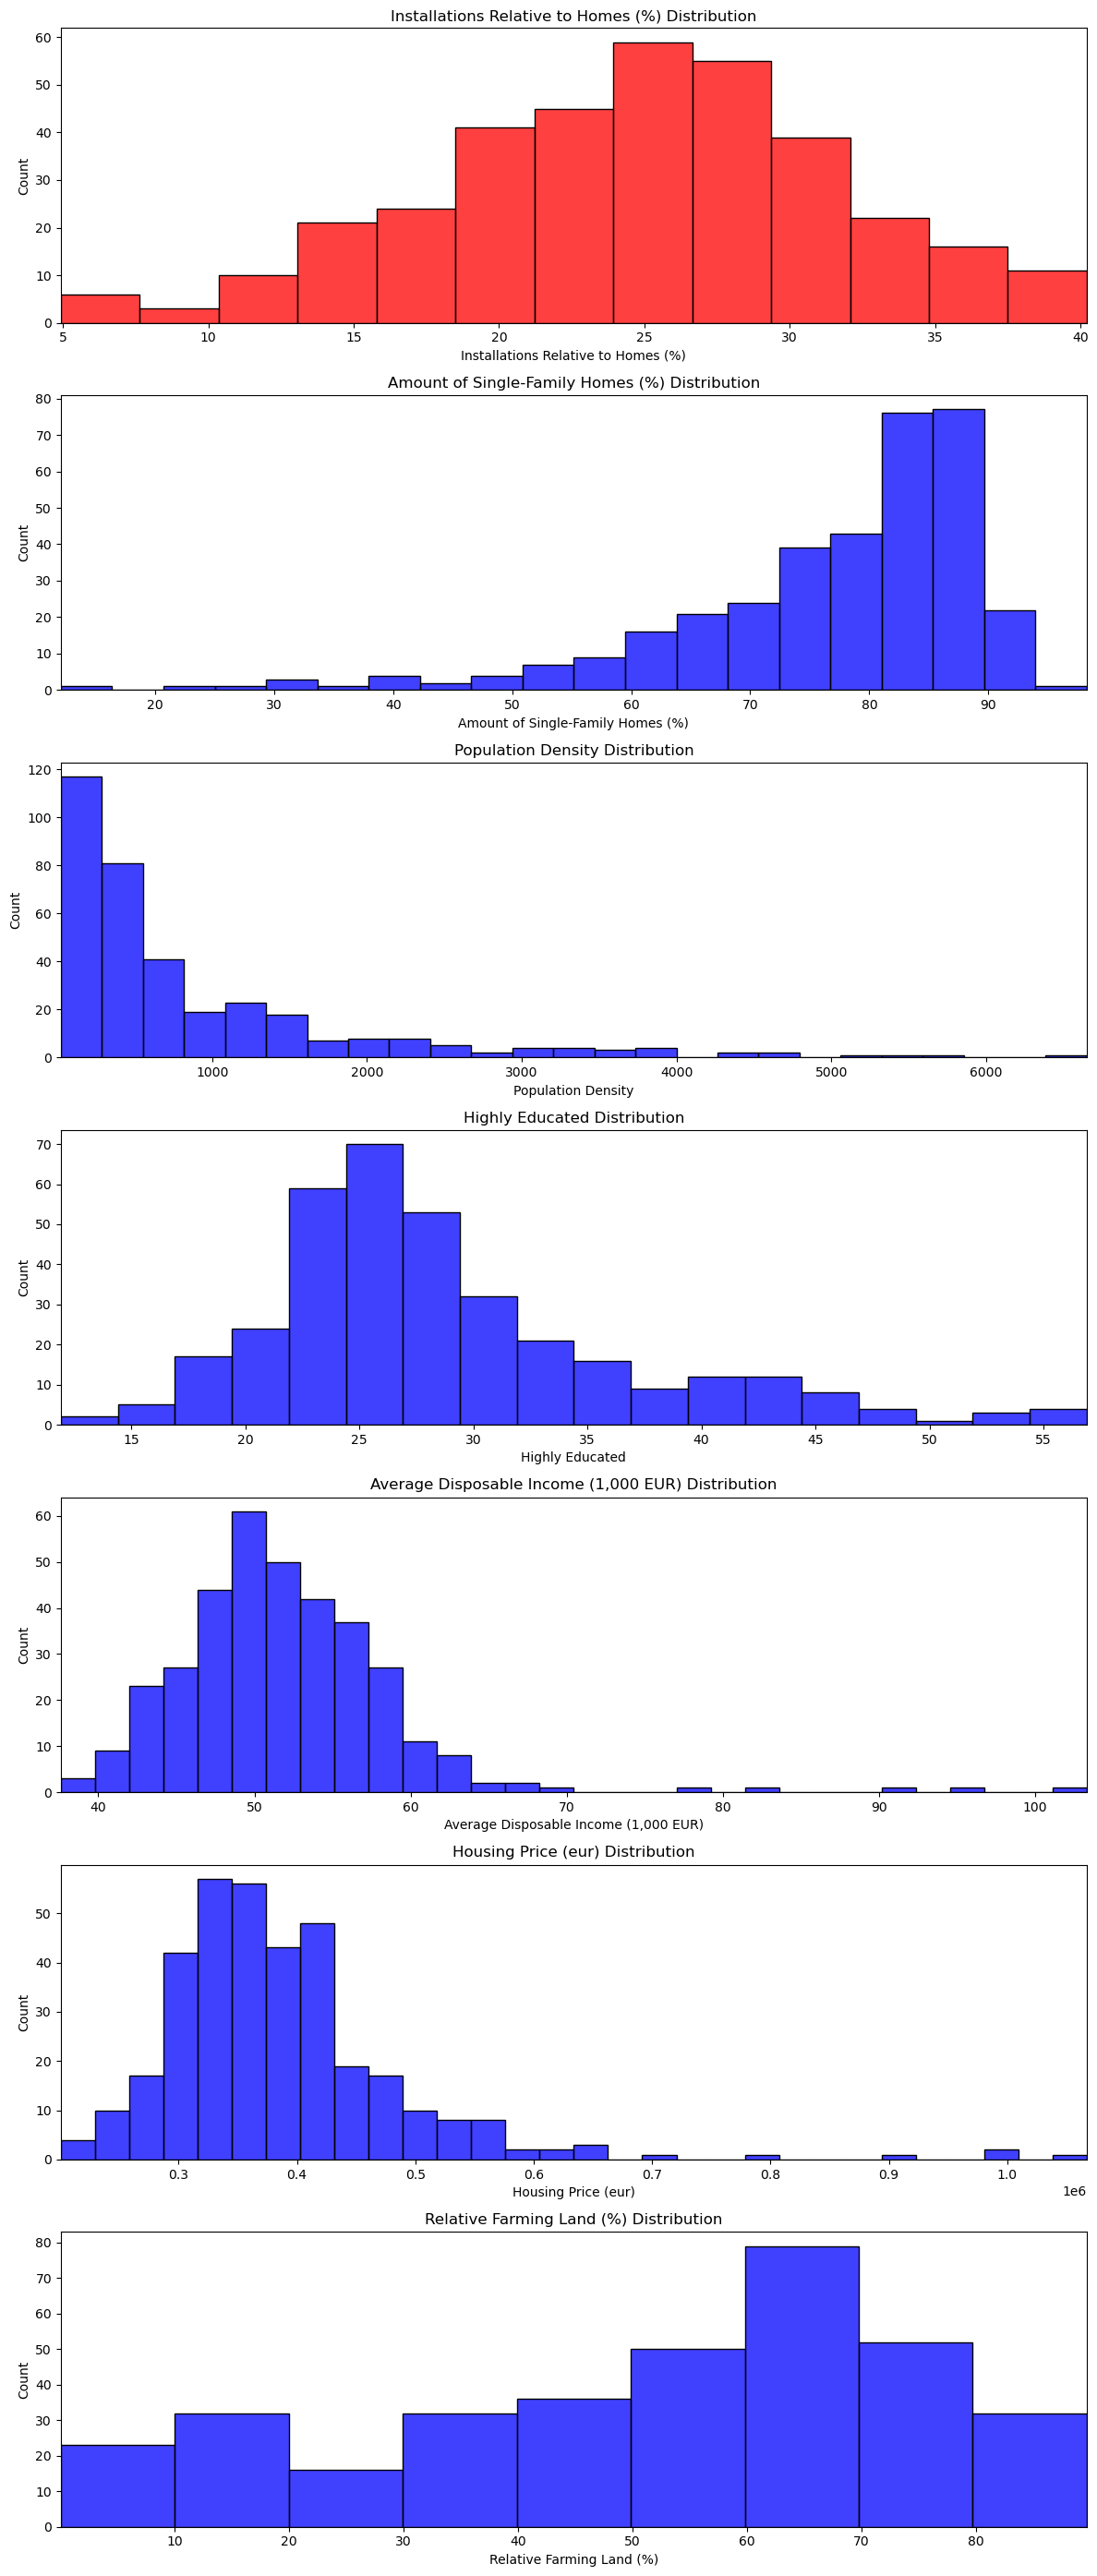

In [938]:
# Set up the figure with an appropriate size for the number of columns
fig, axes = plt.subplots(len(columns), 1, figsize=(12, len(columns) * 4))

# Loop through each column and plot the distribution
for i, col in enumerate(columns):
    color = 'red' if i == 0 else 'blue'  # First column is red, others are blue
    
    # Dynamically calculate the number of bins using the Freedman-Diaconis rule
    col_data = df[col].dropna()  # Drop NaN values to avoid errors
    q25, q75 = col_data.quantile(0.25), col_data.quantile(0.75)
    iqr = q75 - q25  # Interquartile range
    bin_width = 2 * iqr / len(col_data) ** (1/3) if iqr > 0 else 1  # Bin width
    num_bins = max(1, int((col_data.max() - col_data.min()) / bin_width))  # Number of bins

    # Plot the histogram with dynamic bins
    sns.histplot(col_data, kde=False, bins=num_bins, ax=axes[i], color=color)

    # Dynamically set x-axis limits based on the column's data range
    col_min, col_max = col_data.min(), col_data.max()
    axes[i].set_xlim(col_min, col_max)
    
    # Set the title
    axes[i].set_title(f"{col} Distribution")

# Adjust layout
plt.tight_layout()
plt.show()


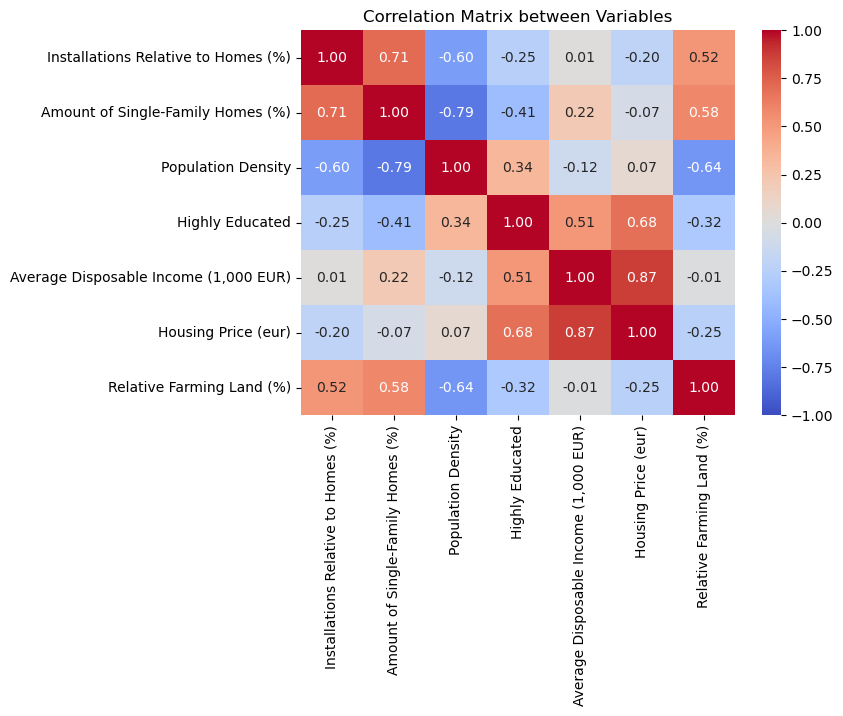

In [939]:


# Calculate the correlation matrix
corr_matrix = df[columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", cbar=True)
plt.title("Correlation Matrix between Variables")
plt.show()

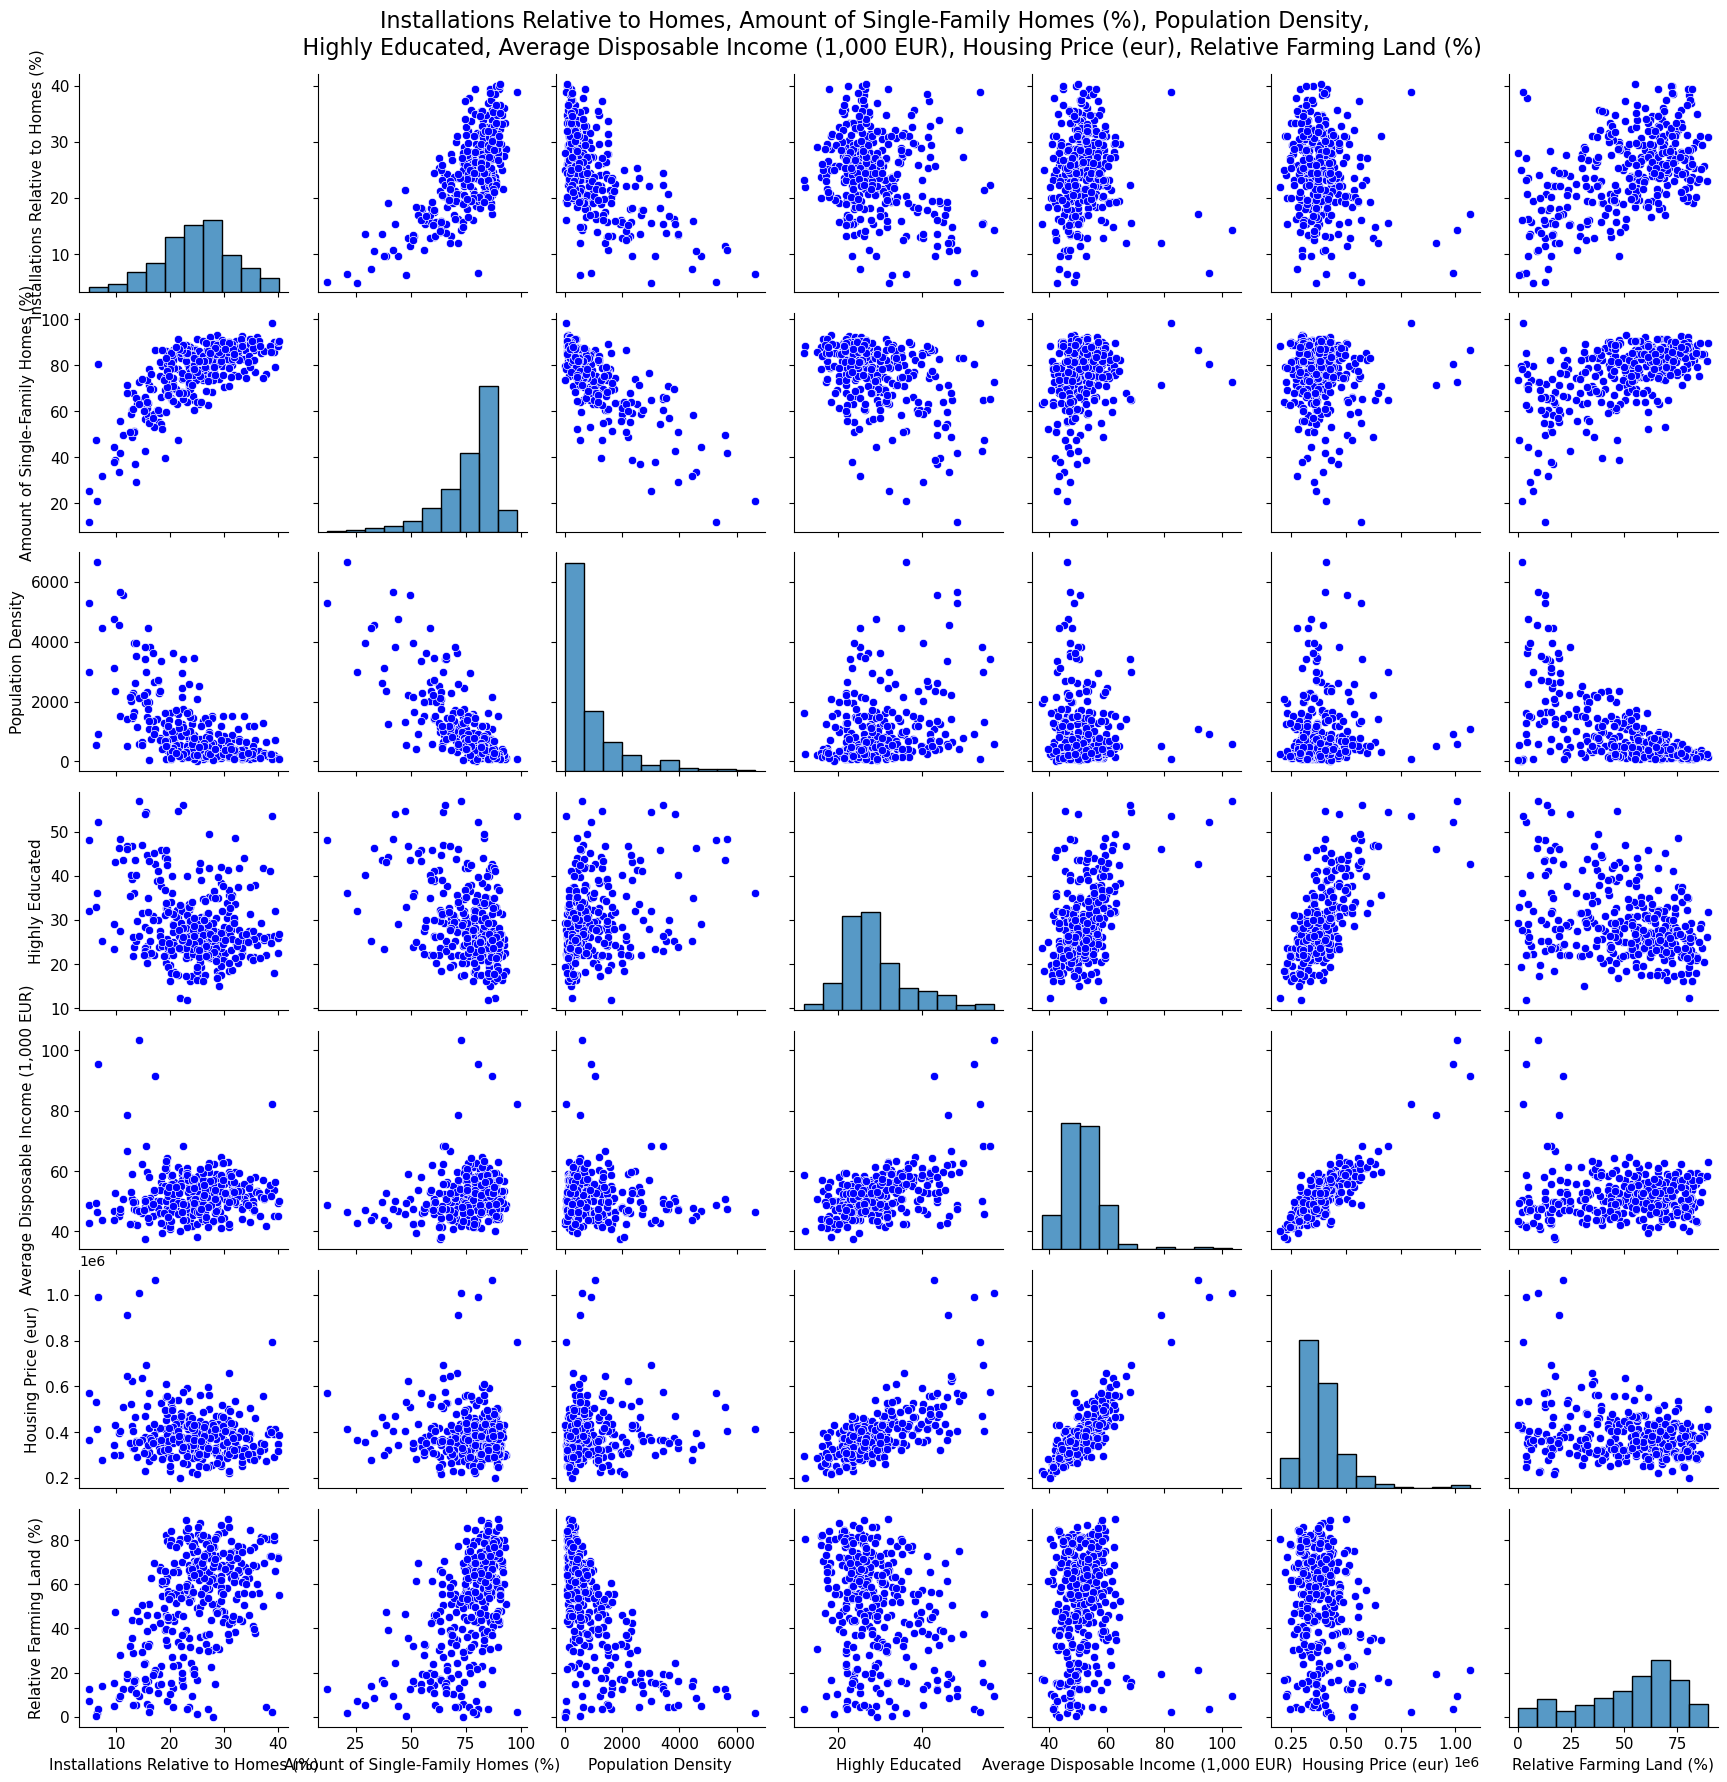

In [940]:
# Used a pairgrid for more options when customizing
grid = sns.PairGrid(df[columns])

# Use blue so '% Non-agricultural Workers' stands out
grid.map_offdiag(sns.scatterplot, color="blue")  

# Customize diagonal histograms
def diagonal_hist(x, **kwargs):
    # Determine the color based on the column name
    if x.name in ['Installations Relative to Homes']:
        sns.histplot(x, kde=False, bins=10, color='red', **{k: v for k, v in kwargs.items() if k != 'color'})
    else:
        sns.histplot(x, kde=False, bins=10, **kwargs)

grid.map_diag(diagonal_hist)

# Customize font size for titles, labels, and ticks
grid.fig.suptitle(
    '''Installations Relative to Homes, Amount of Single-Family Homes (%), Population Density, 
    Highly Educated, Average Disposable Income (1,000 EUR), Housing Price (eur), Relative Farming Land (%)''',
    y=1.02, fontsize=16
)

# Set font size for axis labels and ticks
for ax in grid.axes.flat:
    ax.tick_params(labelsize=11)  # Adjust tick label size
    ax.set_xlabel(ax.get_xlabel(), fontsize=11)  # Adjust x-axis label size
    ax.set_ylabel(ax.get_ylabel(), fontsize=11)  # Adjust y-axis label size

plt.show()


In [941]:
df.sort_values('Installations Relative to Homes (%)', ascending=True)[:5]

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Installations Relative to Homes (%),Capacity relative to homes,Population Density,Highly Educated,"Average Disposable Income (1,000 EUR)",Average Age,Housing Price (eur),Relative Farming Land (%),Province
250,Rotterdam,2021,"POLYGON ((461973.441 6797665.895, 461861.132 6...",25.540581,74.459419,55.074547,4.924437,15.278429,2995.316019,32.1,42.8,39.9700,364018.0,7.156960,Zuid-Holland
17,Amsterdam,2021,"MULTIPOLYGON (((554520.905 6860158.026, 554532...",12.084740,87.915260,61.718824,5.048123,14.393463,5276.966767,48.2,48.7,39.3150,569890.0,12.469816,Noord-Holland
340,Zandvoort,2021,"POLYGON ((506883.615 6858963.25, 506205.598 68...",47.702452,52.297548,44.500048,6.243561,22.048218,534.495641,32.9,49.6,46.7600,529740.0,0.250171,Noord-Holland
0,'s-Gravenhage,2021,"MULTIPOLYGON (((466450.087 6810765.01, 466580....",21.171308,78.828692,63.223156,6.450994,18.894642,6650.333535,36.2,46.3,39.8550,411717.0,1.803730,Zuid-Holland
166,Laren,2021,"POLYGON ((581755.876 6848710.476, 581769.995 6...",80.444771,19.555229,11.170627,6.616431,28.377137,918.452861,52.3,95.4,48.0325,989352.0,3.706688,Noord-Holland


In [942]:
df.sort_values('Installations Relative to Homes (%)', ascending=False)[:5]

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Installations Relative to Homes (%),Capacity relative to homes,Population Density,Highly Educated,"Average Disposable Income (1,000 EUR)",Average Age,Housing Price (eur),Relative Farming Land (%),Province
323,Westerveld,2021,"POLYGON ((704803.926 6965912.876, 705017.565 6...",90.541331,9.458669,11.436085,40.219806,146.089092,70.634094,26.8,50.2,48.2575,386678.0,55.107166,Drenthe
222,Ooststellingwerf,2021,"POLYGON ((708737.095 6994339.928, 708738.888 6...",90.130484,9.869516,17.792832,40.003503,137.761625,113.973682,22.5,45.0,45.5275,319631.0,71.987086,Fryslân
190,Midden-Drenthe,2021,"POLYGON ((722750.612 6981717.711, 722751.363 6...",88.496496,11.503504,14.385210,39.970860,148.123222,98.032363,25.8,49.4,45.5425,349627.0,72.431839,Drenthe
288,Uitgeest,2021,"POLYGON ((525313.36 6900338.77, 525319.213 690...",79.259777,20.740223,13.728383,39.455307,114.437849,711.482255,32.0,56.3,42.1075,413903.0,65.903993,Noord-Holland
69,De Wolden,2021,"POLYGON ((707356.065 6945188.763, 707281.825 6...",85.984704,14.015296,10.679228,39.359465,144.971319,108.545981,26.4,53.9,45.4000,390775.0,81.740667,Drenthe


In [943]:
# Generate descriptive statistics for the specified columns
descriptive_stats = df[columns].describe().transpose()

# Reset the index to make it easier to plot
descriptive_stats.reset_index(inplace=True)
descriptive_stats.rename(columns={'index': 'Column'}, inplace=True)

# Display the descriptive statistics
print(descriptive_stats)

                                  Column  count           mean            std  \
0    Installations Relative to Homes (%)  352.0      24.730585       7.007939   
1      Amount of Single-Family Homes (%)  352.0      76.808127      13.166320   
2                     Population Density  352.0     891.286831    1057.013803   
3                        Highly Educated  352.0      28.805185       8.083438   
4  Average Disposable Income (1,000 EUR)  352.0      51.932670       7.196876   
5                    Housing Price (eur)  352.0  387498.340909  106734.491261   
6              Relative Farming Land (%)  352.0      51.640516      23.264340   

             min            25%            50%            75%           max  
0       4.924437      20.121674      25.241419      29.296898  4.021981e+01  
1      12.084740      71.252015      80.883141      85.955263  9.827089e+01  
2      22.841021     240.157405     469.323448    1163.058045  6.650334e+03  
3      11.900000      23.400000      26

### ESDA

In [944]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Define predictors and dependent variable
predictors = [
    'Amount of Single-Family Homes (%)',
    #'Amount of Multi-Family Homes (%)',
    # 'Amount of Flat Roof Area (%)',
    'Population Density',
    'Highly Educated',
    'Average Disposable Income (1,000 EUR)',
    # 'Average Age',
    'Housing Price (eur)',
    'Relative Farming Land (%)'
]
y = df['Installations Relative to Homes (%)']

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[predictors])

# Convert scaled predictors to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Add dummy variables if there's a categorical column (e.g., Region)
# Example if 'Region' exists:
# region_dummies = pd.get_dummies(df['Region'], prefix='Region', drop_first=True)
# Combine predictors and dummy variables
# X_combined = pd.concat([X_scaled_df, region_dummies], axis=1)
X_combined = X_scaled_df  # Use this if no dummy variables are needed

# Add a constant for the regression model
X = sm.add_constant(X_combined)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Model Performance
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

# Output results
print(model.summary())
print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")


                                     OLS Regression Results                                    
Dep. Variable:     Installations Relative to Homes (%)   R-squared:                       0.601
Model:                                             OLS   Adj. R-squared:                  0.593
Method:                                  Least Squares   F-statistic:                     68.92
Date:                                 Tue, 28 Jan 2025   Prob (F-statistic):           6.43e-52
Time:                                         15:41:36   Log-Likelihood:                -830.23
No. Observations:                                  281   AIC:                             1674.
Df Residuals:                                      274   BIC:                             1700.
Df Model:                                            6                                         
Covariance Type:                             nonrobust                                         
                                        

In [945]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_combined.columns
vif_data["VIF"] = [variance_inflation_factor(X_combined.values, i) for i in range(X_combined.shape[1])]
print(vif_data)


                                 Feature       VIF
0      Amount of Single-Family Homes (%)  3.880482
1                     Population Density  3.277019
2                        Highly Educated  2.552068
3  Average Disposable Income (1,000 EUR)  6.639238
4                    Housing Price (eur)  7.722339
5              Relative Farming Land (%)  2.006062


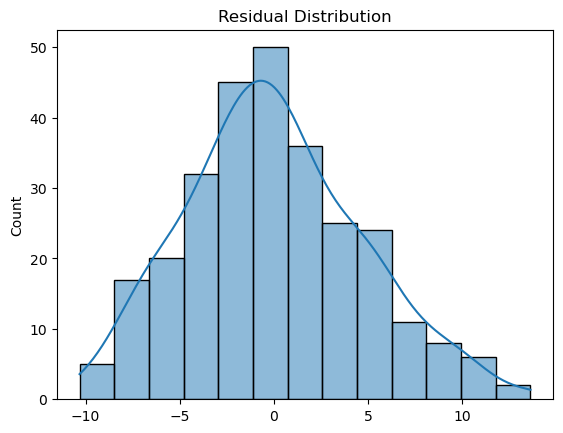

In [946]:
residuals = y_train - y_pred_train
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

In [947]:
from itertools import combinations
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


y = df['Installations Relative to Homes (%)']

# Standardize the predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[predictors])
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# Create interaction terms (pairwise combinations of predictors)
interaction_terms = []
for comb in combinations(X_scaled_df.columns, 2):
    col_name = f"{comb[0]}_x_{comb[1]}"
    X_scaled_df[col_name] = X_scaled_df[comb[0]] * X_scaled_df[comb[1]]
    interaction_terms.append(col_name)

# Combine original predictors and interaction terms
X_combined = X_scaled_df  # Now includes interaction terms

# Add a constant for regression
X = sm.add_constant(X_combined)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model with interaction terms
model = sm.OLS(y_train, X_train).fit()

# Model summary
print(model.summary())

# Evaluate model performance
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")

# List all interaction terms
print("\nInteraction Terms Included:")
for term in interaction_terms:
    print(term)


                                     OLS Regression Results                                    
Dep. Variable:     Installations Relative to Homes (%)   R-squared:                       0.623
Model:                                             OLS   Adj. R-squared:                  0.593
Method:                                  Least Squares   F-statistic:                     20.40
Date:                                 Tue, 28 Jan 2025   Prob (F-statistic):           2.19e-43
Time:                                         15:41:36   Log-Likelihood:                -822.33
No. Observations:                                  281   AIC:                             1689.
Df Residuals:                                      259   BIC:                             1769.
Df Model:                                           21                                         
Covariance Type:                             nonrobust                                         
                                        

In [948]:
df.sort_values('Highly Educated', ascending=False)[:5]

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Installations Relative to Homes (%),Capacity relative to homes,Population Density,Highly Educated,"Average Disposable Income (1,000 EUR)",Average Age,Housing Price (eur),Relative Farming Land (%),Province
42,Bloemendaal,2021,"POLYGON ((514080.641 6877309.417, 514084.809 6...",72.693291,27.306709,20.503151,14.233720,50.216408,590.047751,56.9,103.3,45.9325,1007936.0,9.330091,Noord-Holland
212,Oegstgeest,2021,"POLYGON ((498740.223 6836723.454, 498741.57 68...",65.462139,34.537861,29.308253,22.344289,71.772290,3428.727770,56.1,68.2,42.2175,575022.0,13.801757,Zuid-Holland
315,Wageningen,2021,"POLYGON ((636926.327 6799018.278, 636907.933 6...",47.368130,52.631870,36.411217,21.430941,68.141104,1302.925707,54.7,45.7,39.6650,403316.0,46.662546,Gelderland
124,Heemstede,2021,"POLYGON ((512978.231 6866022.058, 512981.728 6...",64.851369,35.148631,23.462575,15.573067,48.490286,3000.544662,54.4,68.4,45.4625,694937.0,15.560166,Noord-Holland
291,Utrecht,2021,"POLYGON ((556925.894 6825805.72, 556883.23 682...",42.841217,57.158783,46.955150,15.314616,46.966575,3830.011723,54.1,50.2,36.7700,469949.0,24.362463,Utrecht


In [949]:
df.sort_values('Capacity relative to homes', ascending=True)[:10]

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Installations Relative to Homes (%),Capacity relative to homes,Population Density,Highly Educated,"Average Disposable Income (1,000 EUR)",Average Age,Housing Price (eur),Relative Farming Land (%),Province
17,Amsterdam,2021,"MULTIPOLYGON (((554520.905 6860158.026, 554532...",12.084740,87.915260,61.718824,5.048123,14.393463,5276.966767,48.2,48.7,39.3150,569890.0,12.469816,Noord-Holland
250,Rotterdam,2021,"POLYGON ((461973.441 6797665.895, 461861.132 6...",25.540581,74.459419,55.074547,4.924437,15.278429,2995.316019,32.1,42.8,39.9700,364018.0,7.156960,Zuid-Holland
0,'s-Gravenhage,2021,"MULTIPOLYGON (((466450.087 6810765.01, 466580....",21.171308,78.828692,63.223156,6.450994,18.894642,6650.333535,36.2,46.3,39.8550,411717.0,1.803730,Zuid-Holland
340,Zandvoort,2021,"POLYGON ((506883.615 6858963.25, 506205.598 68...",47.702452,52.297548,44.500048,6.243561,22.048218,534.495641,32.9,49.6,46.7600,529740.0,0.250171,Noord-Holland
255,Schiedam,2021,"POLYGON ((487541.501 6793399.923, 487559.421 6...",31.871798,68.128202,54.775405,7.376174,25.669833,4448.877666,25.2,43.7,41.4700,279445.0,13.897281,Zuid-Holland
304,Vlaardingen,2021,"POLYGON ((484423.593 6791125.014, 484675.566 6...",37.962364,62.037636,53.410685,9.622795,27.523839,3136.359779,23.3,43.9,42.9400,301858.0,15.286624,Zuid-Holland
58,Capelle aan den IJssel,2021,"POLYGON ((511180.398 6792643.818, 511246.351 6...",44.340221,55.659779,40.453388,9.690709,28.134111,4760.891089,29.1,46.8,42.9375,343101.0,4.870130,Zuid-Holland
166,Laren,2021,"POLYGON ((581755.876 6848710.476, 581769.995 6...",80.444771,19.555229,11.170627,6.616431,28.377137,918.452861,52.3,95.4,48.0325,989352.0,3.706688,Noord-Holland
70,Delft,2021,"POLYGON ((486867.672 6806003.81, 486879.662 68...",33.521701,66.478299,49.362021,10.575784,31.061268,4573.112583,46.4,45.2,39.8825,395478.0,8.686617,Zuid-Holland
170,Leidschendam-Voorburg,2021,"POLYGON ((497258.774 6823460.414, 497317.712 6...",38.760655,61.239345,43.615002,9.711812,31.898255,2348.172043,43.1,52.8,43.9900,432286.0,47.501404,Zuid-Holland


In [950]:
df['Installations Relative to Homes (%)'].describe()

count    352.000000
mean      24.730585
std        7.007939
min        4.924437
25%       20.121674
50%       25.241419
75%       29.296898
max       40.219806
Name: Installations Relative to Homes (%), dtype: float64